In [531]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [532]:
%cd /gdrive/MyDrive/AN2DL/Homework1/

/gdrive/MyDrive/AN2DL/Homework1


### Import Libraries

In [533]:
! pip install git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-q8by9z80
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-q8by9z80


In [534]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import albumentations as A
from functools import partial
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import cv2
import gc
from tensorflow.keras.mixed_precision import experimental as mixed_precision

tfk = tf.keras
tfkl = tf.keras.layers

AUTOTUNE = tf.data.experimental.AUTOTUNE

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [535]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Metadata

In [536]:
# Model configuration
image_size = 256
input_shape = (image_size, image_size, 3)

epochs = 100
batch_size = 32
n_classes = 14

model_name = "cnn"

### Dataframe Loader

In [537]:
df_train = pd.read_csv("full_dataset.csv")
#training_folder = '../input/cassava-leaf-disease-classification/train_images/'
#df_train["filepath"] = training_folder+df_train["image_id"]
df_train.head()

image_id  label                      filepath
0  00334.jpg      0  full_dataset/Apple/00334.jpg
1  22703.jpg      0  full_dataset/Apple/22703.jpg
2  00310.jpg      0  full_dataset/Apple/00310.jpg
3  00234.jpg      0  full_dataset/Apple/00234.jpg
4  22823.jpg      0  full_dataset/Apple/22823.jpg

# Converting data to tf.data

So, some of you might be wondering why go through all the trouble to convert our data to a tf.data implementation when we can just use the built-in tensorflow/keras functions and avoid all this hassle and complications? Here are two main reasons:

1. Python executes code eagerly (sequentially) by default, as do pandas and numpy. This means that the ability to run code in parallel with a GPU (multi-processing) is not utilized fully if you don't specify. TF.data maximizes parallel code execution by converting your code into Tensorflow graphs and tensors (in a nutshell), so it runs faster.

2. Like I mentioned earlier, tf.data offers much more functionality, flexibility and customization for your code than in-built functions. In our case, you can manipulate images much more intricately with tf.data than you can with in-built functions. We are able to implement CutMix(up) exactly because of this. 

Here are some links in case you want to reaed up more:
- https://www.tensorflow.org/guide/data_performance
- https://stackoverflow.com/questions/54894799/why-should-i-use-tf-data

*Disclaimer: I'm not making full use of tf.data functionality in this notebook. The problem with many notebooks utilizing tf.data is that they are too complex and not beginner-friendly. I aim to change that in this notebook and offer a introductory example of tf.data for further exploration. That is to say, tf.data can be implemented much more efficiently and as a result; run faster. This notebook only has barebones functionality to accomodate the necessary image augmentations.*

In [538]:
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train_index, val_index in skf.split(df_train["image_id"], df_train["label"]):
    train_data = df_train.loc[train_index]
    val_data = df_train.loc[val_index]

In [539]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

![](https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data-pipeline-1.png)

The first step is to read in data from our csv file and images, convert them into tf.tensors with the features and labels assigned. You can think of tensors as small data blocks, whose sizes we can specify with "batch size".

In [540]:
training_data = tf.data.Dataset.from_tensor_slices((train_data["filepath"].values, train_data["label"].values))
validation_data = tf.data.Dataset.from_tensor_slices((val_data["filepath"].values, val_data["label"].values))

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

# Image augmentation
Next, we still specify our image augmentations in Albumentations and map them to our tf.tensors.

In [541]:
def augment_train_data(train_ds):
    transforms = A.Compose([
            A.RandomResizedCrop(image_size, image_size),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            ], p=1)
    
    def aug_fn(image):
        data = {"image":image}
        aug_data = transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label
    
    def set_shapes(img, label, img_shape=(image_size, image_size, 3)):
        img.set_shape(img_shape)
        label.set_shape([])
        return img, label
    
    ds_alb = train_ds.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE)
    ds_alb = ds_alb.repeat()
    ds_alb = ds_alb.batch(batch_size)
    return ds_alb

In [542]:
def augment_val_data(val_ds):
    transforms = A.Compose([
                A.CenterCrop(image_size, image_size),
                ], p=1)
    
    def aug_fn(image):
        data = {"image":image}
        aug_data = transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label
    
    def set_shapes(img, label, img_shape=(image_size,image_size,3)):
        img.set_shape(img_shape)
        label.set_shape([])
        return img, label
    
    ds_alb = val_ds.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(batch_size)
    return ds_alb

In [543]:
train_alb = augment_train_data(training_data)
val_alb = augment_val_data(validation_data)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [546]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()/255
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(batch_size):
        ax = fig.add_subplot(8, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])

### We can view the images post-augmentation with our "view image" function.

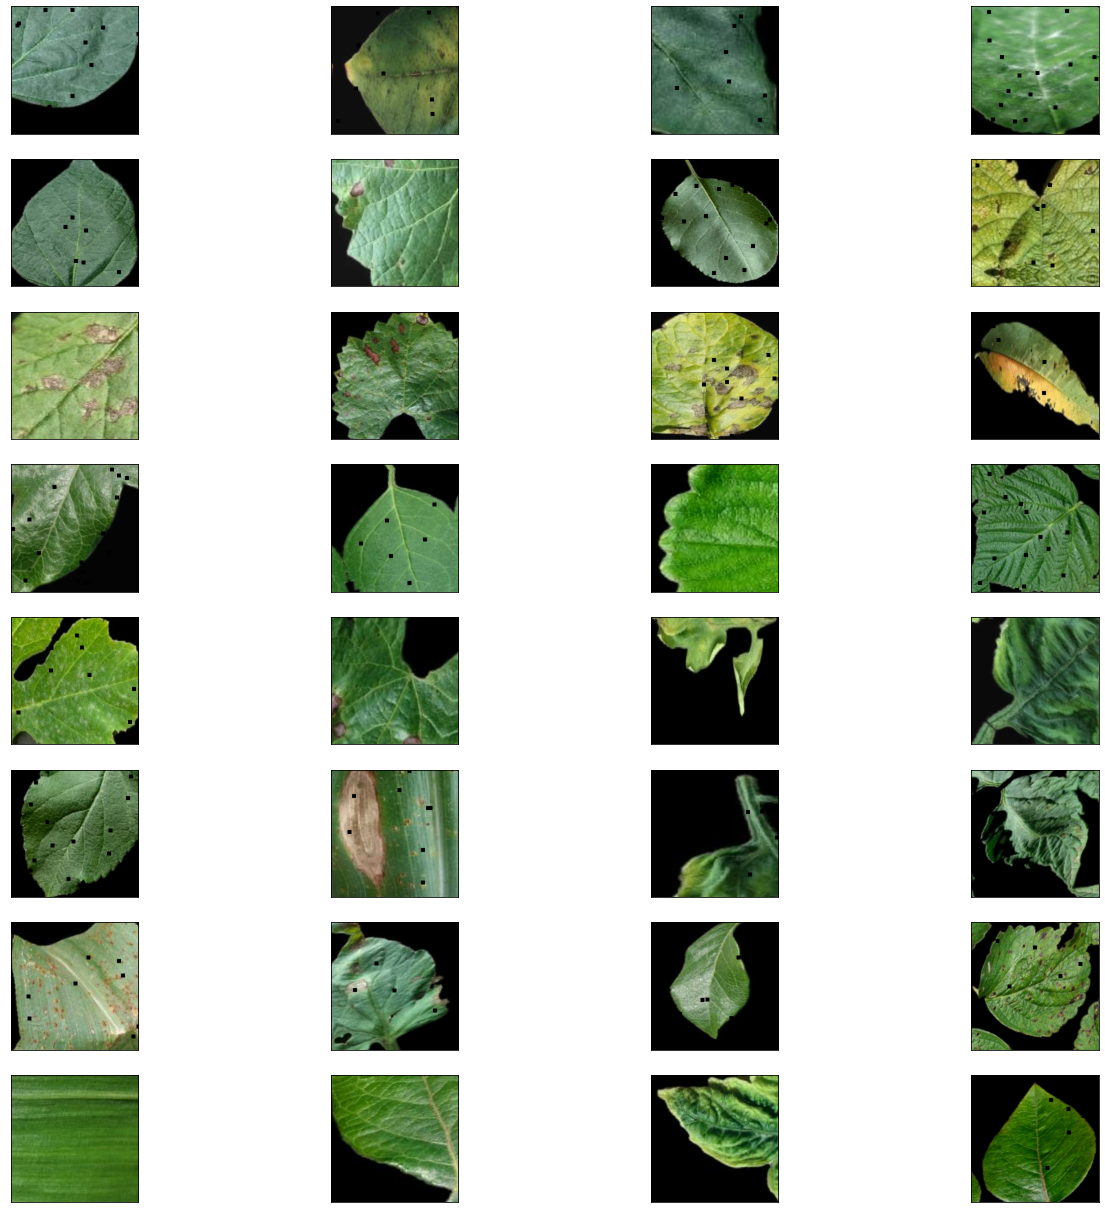

In [547]:
view_image(train_alb)

### Check that validation set remains unchanged!

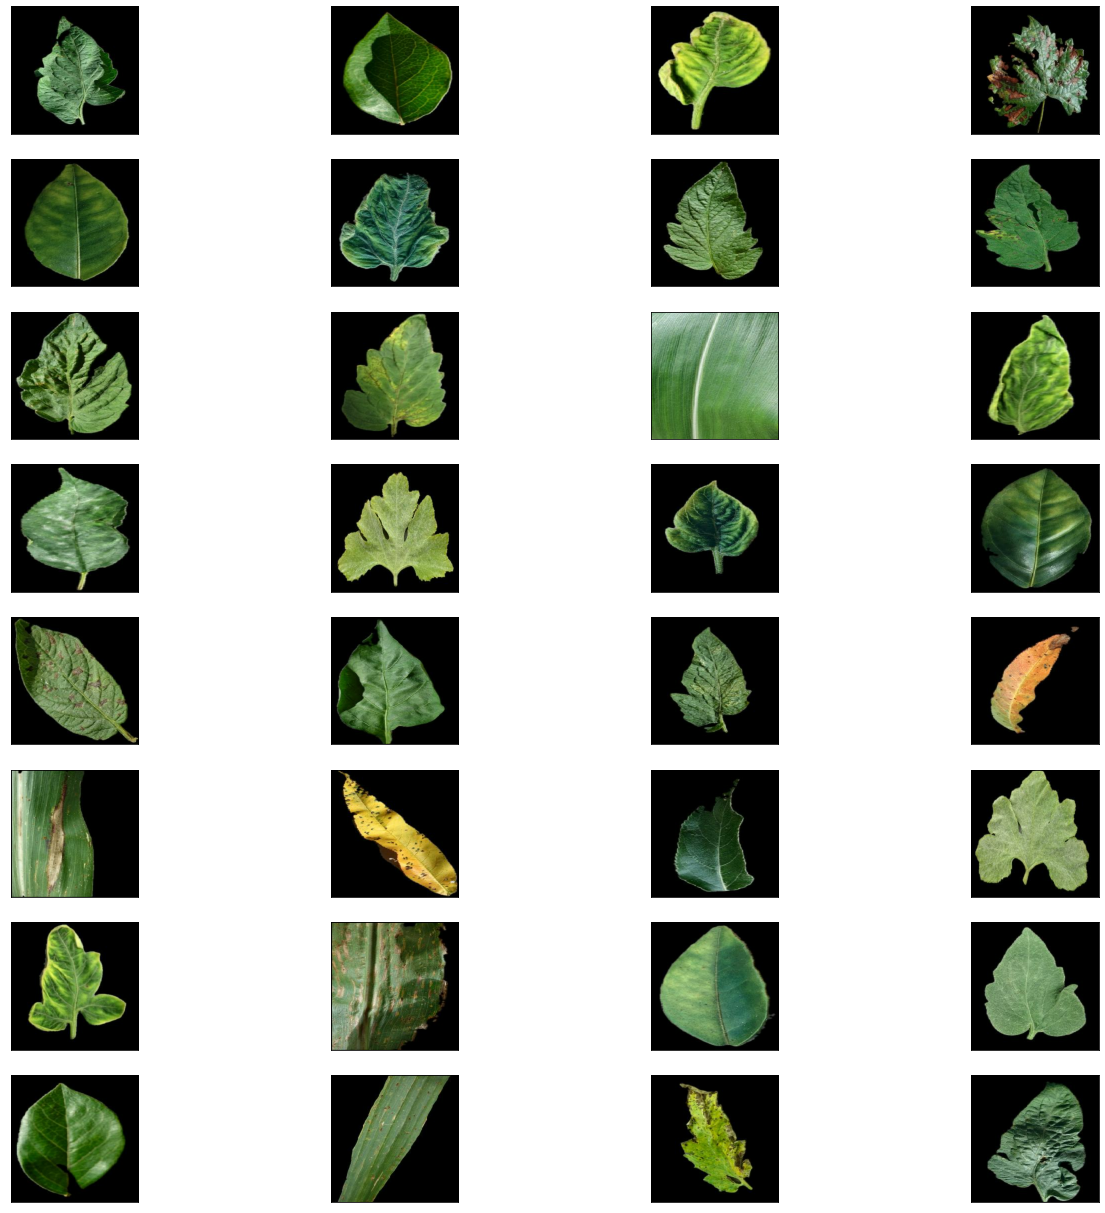

In [548]:
view_image(val_alb)

# CutMix(up)

Great! The primary augmentations through Albumentations are done. Time to implement CutMix(up) on top of them for better generalization and performance of our model.

In [549]:
IMAGE_SIZE = [input_shape[0], input_shape[1]]
AUG_BATCH = batch_size

In [550]:
def cutmix(image, label, PROBABILITY=0.5):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 14
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [551]:
def mixup(image, label, PROBABILITY=0.5):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 14
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [552]:
def transform(image1,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    CLASSES = 14
    SWITCH = 0.5
    CUTMIX_PROB = 0.66
    MIXUP_PROB = 0.66
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP

    image2, label2 = cutmix(image1, label, CUTMIX_PROB)
    image3, label3 = mixup(image1, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])

    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

In [553]:
def onehot(image,label):
    CLASSES = 14 #5
    return image,tf.one_hot(label,CLASSES)

In [554]:
def optimize_data(train_alb, val_alb):

    def configure_for_train(ds):
        ds = ds.map(transform, num_parallel_calls=AUTOTUNE)
        ds = ds.unbatch()
        ds = ds.shuffle(buffer_size=1024)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    def configure_for_val(ds):
        ds = ds.map(onehot, num_parallel_calls=AUTOTUNE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    train_ds = configure_for_train(train_alb)
    val_ds = configure_for_val(val_alb)
    
    return train_ds, val_ds

In [555]:
train_ds, val_ds = optimize_data(train_alb, val_alb)

### Let's see how our images look like after applying CutMix and Mixup:

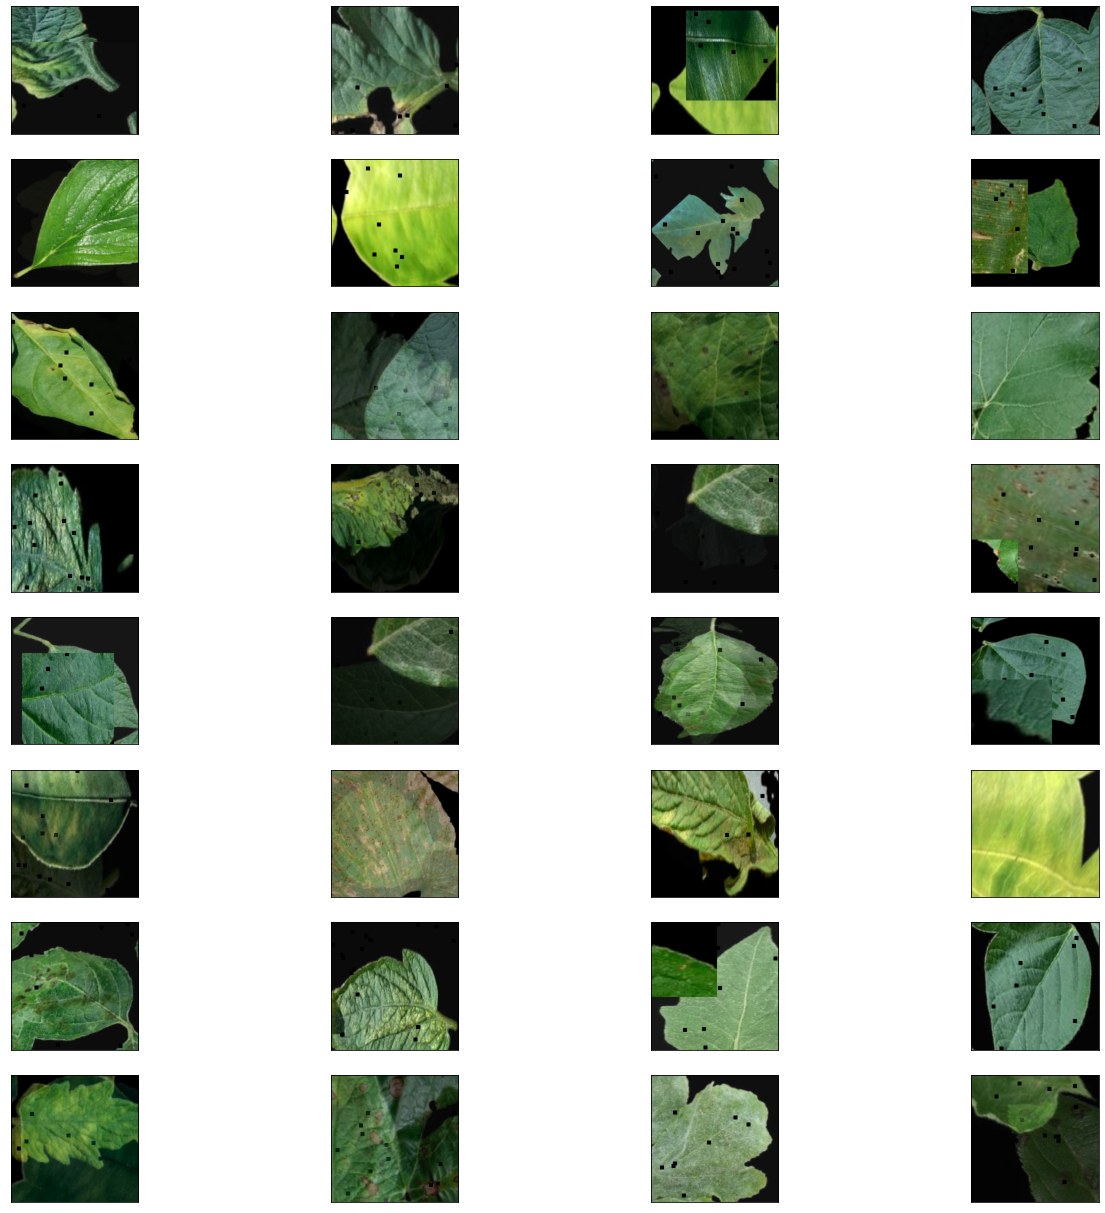

In [556]:
view_image(train_ds)

### Again, make sure the validation set is untouched.

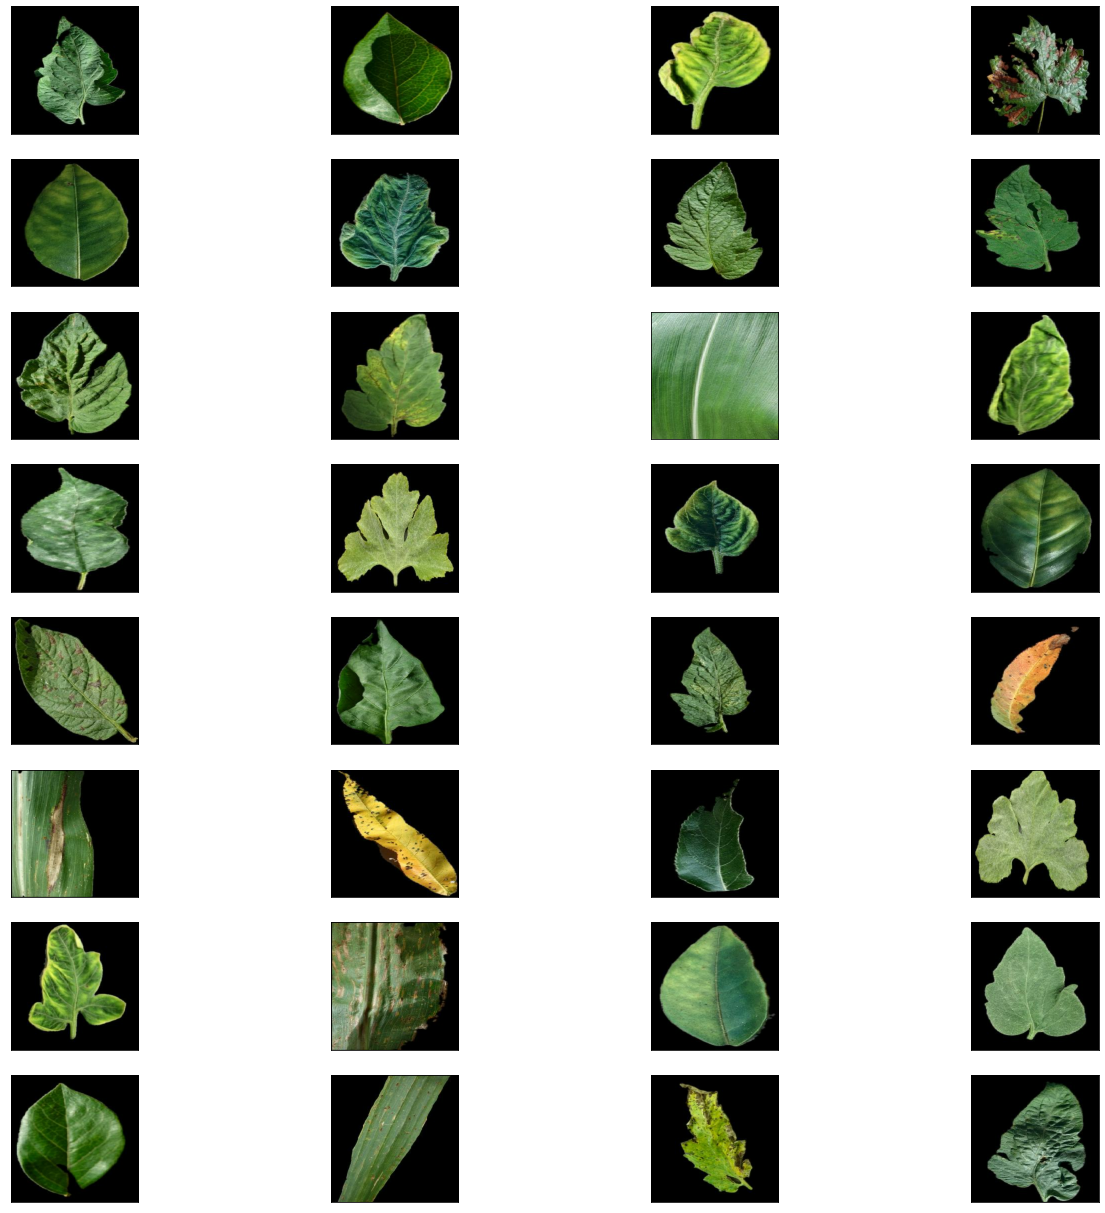

In [557]:
view_image(val_ds)